  # Get pharmacophore fingerprints

- Using multiparallelism and calling **`getPharmacophoresFromRDKit`**
    - Use Jump CP metadata file as input 
    - Compute Pharmacophores for each compound
    - Save pharmacophore vectors as sparse and dense files
    

# Initialization

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [290]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from operator import mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# from KevinsRoutines.utils.utils_general  import  list_namespace 

from itertools import repeat
import more_itertools
from multiprocessing import Pool, process
from os import getpid
from rdkit.Chem import PandasTools

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=10, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 180

['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [3]:
# datetime.now().strftime('%X.%f')
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
print(time.strftime('%x-%X %Z'))
print(datetime.now().strftime('%D-%X.%f'))
print(datetime.now().strftime('%Y-%M-%d %H:%m:%S.%f' ))

import logging 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logging.getLogger("imported_module").setLevel(logging.CRITICAL)

10/17/24-21:33:43 CEST
10/17/24-21:33:43.059771
2024-33-17 21:10:43.059838


In [291]:

from KevinsRoutines.utils.utils_chem import (appendMolFromRDKit, 
                                             fingerprint_to_sparse_matrix,
                                             getPharmacophoresFromRDKit,  my_enumerator, starmap_with_kwargs_async, )

In [1003]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = './output_10162024/')
display_project_datasets(ds)

 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_10162024/

 Input Datasets : 
 ---------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_10162024/compound_metadata_smiles.csv
          + TPSA                             : ./output_10162024/compound_metadata_tpsa.csv
          + TPSA Cleaned (TPSA <> 0)         : ./output_10162024/compound_metadata_tpsa_clean.csv
          + Base64 Pharmacophores            : ./output_10162024/compound_metadads.ta_pcfp.csv

 Compound/TPSA File:
 -------------------
 compou

## Read Jump-CP compound metadata (+ smiles) file

In [7]:
# df = pd.read_csv(ds.compoundMetadataSmilesCleanFile)
# df.info()
# df.head(3)
# df.tail(3)
# df[df['smiles'].isna()]

# df = pd.read_csv(ds.compoundMetadataTPSAFile)
# df.info()
# df_md_zero = df[df['TPSA'] == 0.0]
# print(f" Metadata entries with TPSA == 0.0: {len(df_md_zero)}")
# df_md_nan = df[df['TPSA'].isna()]
# print(f" Metadata entries with TPSA == Nan: {len(df_md_nan)}")
# df_md_inv = pd.concat((df_md_zero, df_md_nan))
# print(f" Metadata entries with TPSA == Nan or 0.0: {len(df_md_inv)}")
# df_md_inv

In [8]:
df = pd.read_csv(ds.compoundMetadataTPSACleanFile)
df.info()
df.head(3)
df.tail(3)
len(df)
df_md_zero = df[df['Metadata_Smiles'].isna()]
print(f" Metadata entries with Smiles == Nan : {len(df_md_zero)}")
df_md_zero = df[df['Metadata_TPSA'] == 0.0]
print(f" Metadata entries with TPSA == 0.0: {len(df_md_zero)}")
df_md_nan = df[df['Metadata_TPSA'].isna()]
print(f" Metadata entries with TPSA == Nan: {len(df_md_nan)}")
df_md_inv = pd.concat((df_md_zero, df_md_nan))
print(f" Metadata entries with TPSA == Nan or 0.0: {len(df_md_inv)}")
df_md_inv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_Hash        116691 non-null  int64  
 2   Metadata_Bin         116691 non-null  int64  
 3   Metadata_InChIKey    116691 non-null  object 
 4   Metadata_InChI       116691 non-null  object 
 5   Metadata_Smiles      116691 non-null  object 
 6   Metadata_TPSA        116691 non-null  float64
 7   Metadata_lnTPSA      116691 non-null  float64
 8   Metadata_logTPSA     116691 non-null  float64
 9   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,8228137599824226564,0,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
116688,JCP2022_116751,5024933905542715644,0,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116689,JCP2022_116752,8043583690001075349,9,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116690,JCP2022_116753,-9112886486787329276,4,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


116691

 Metadata entries with Smiles == Nan : 0
 Metadata entries with TPSA == 0.0: 0
 Metadata entries with TPSA == Nan: 0
 Metadata entries with TPSA == Nan or 0.0: 0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation


# Calculate pharmacophores using multiprocessing 

In [17]:
# from KevinsRoutines.utils.utils_chem import  my_callback, my_error_callback
# del my_enumerator, my_callback, my_error_callback, apply_args_and_kwargs, starmap_with_kwargs_async, getPharmacophoresFromRDKit
# from KevinsRoutines.utils.utils_chem import my_enumerator, my_callback, my_error_callback, apply_args_and_kwargs, starmap_with_kwargs_async
del getPharmacophoresFromRDKit
from KevinsRoutines.utils.utils_chem import getPharmacophoresFromRDKit
# from KevinsRoutines.utils.utils_chem import starmap_with_kwargs_async



In [18]:
nrows = 60000
chunksize = 10000
progress_int = 1000
processes = 6
call_function  = getPharmacophoresFromRDKit
kwargs = {'append_pharmacophore' : False, 'progress_int' : progress_int}

print(f"Read metadata file : {ds.compoundMetadataTPSACleanFile}")

enumerator = my_enumerator()
df_iterator  = pd.read_csv(ds.compoundMetadataTPSACleanFile, header=0,  chunksize=chunksize)
df_iterator
args = zip(enumerator, df_iterator)
# dd = next(df_iterator)
# type(dd)
# dd.info()
# dd.head(4)

Read metadata file : ./output_10162024/compound_metadata_tpsa_clean.csv


In [19]:
## If this is executed, reinitialize enumerator and df_iterator before running 
## starmap_with_kwargs_async
# for arg in args:
#     print(arg[0], len(arg[1]))

In [20]:
# result = pool.starmap_async(get_pharmacophores, enumerate(df_iterator))

results = starmap_with_kwargs_async(fn=call_function, args=args, kwargs = kwargs, processes = processes)


 10/17/24-21:40:19 | starmap_with_kwargs_async() | Started  
 starmap_with_kwargs_async parameters
   processes  : 6
   fn         : <function getPharmacophoresFromRDKit at 0x7fc3cb9a7380>       
   args_iter  : <class 'zip'> 
   kwargs_iter: <class 'dict'> : {'append_pharmacophore': False, 'progress_int': 1000}

<multiprocessing.pool.Pool state=RUN pool_size=6>
 10/17/24-21:40:20 | entering apply_args_and_kwargs() 
   apply_args_and_kwargs for part 0 
   fn:      <class 'function'>    - <function getPharmacophoresFromRDKit at 0x7fc3cb9a7380> 
   args:    <class 'tuple'>  - 2:  args[0]: 0   args[1]: <class 'pandas.core.frame.DataFrame'> 
   kwargs:  <class 'dict'>- <class 'dict'>  {'append_pharmacophore': False, 'progress_int': 1000} 
 10/17/24-21:40:20 | exiting apply_args_and_kwargs() 
 
 progress_int : 1000

 ------------------------------------------------------------------------- 
 21:40:20.040654 | chunk_id: 0 | process started - chunk sz: 10000  append_phar: False
 -------------

[21:40:20] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)

[21:40:21] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[21:40:23] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)

[21:40:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 21:40:26.925512 | chunk_id: 3 | 1000 rows processed 


[21:40:27] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[21:40:27] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:40:27.651376 | chunk_id: 2 | 1000 rows processed 
 21:40:28.359433 | chunk_id: 1 | 1000 rows processed 
 21:40:28.520805 | chunk_id: 5 | 1000 rows processed 
 21:40:29.051858 | chunk_id: 4 | 1000 rows processed 


[21:40:31] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 21:40:32.723466 | chunk_id: 0 | 1000 rows processed 


[21:40:34] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:40:35.249991 | chunk_id: 2 | 2000 rows processed 


[21:40:35] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:40:36.824389 | chunk_id: 4 | 2000 rows processed 
 21:40:42.093668 | chunk_id: 2 | 3000 rows processed 
 21:40:42.551277 | chunk_id: 0 | 2000 rows processed 
 21:40:43.118086 | chunk_id: 1 | 2000 rows processed 
 21:40:46.795425 | chunk_id: 4 | 3000 rows processed 


[21:40:47] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

[21:40:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 21:40:50.582122 | chunk_id: 2 | 4000 rows processed 
 21:40:51.309237 | chunk_id: 1 | 3000 rows processed 
 21:40:51.387461 | chunk_id: 0 | 3000 rows processed 


[21:40:53] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[21:40:53] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:40:57.210650 | chunk_id: 2 | 5000 rows processed 
 21:40:58.843560 | chunk_id: 1 | 4000 rows processed 
 21:41:00.584321 | chunk_id: 0 | 4000 rows processed 
 21:41:06.802072 | chunk_id: 1 | 5000 rows processed 
 21:41:12.086770 | chunk_id: 0 | 5000 rows processed 
 21:41:13.673706 | chunk_id: 1 | 6000 rows processed 
 21:41:21.720665 | chunk_id: 2 | 6000 rows processed 
 21:41:24.107006 | chunk_id: 1 | 7000 rows processed 
 21:41:28.238332 | chunk_id: 2 | 7000 rows processed 
 21:41:36.917855 | chunk_id: 2 | 8000 rows processed 


[21:41:46] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:41:47.265697 | chunk_id: 2 | 9000 rows processed 
 21:41:49.088762 | chunk_id: 1 | 8000 rows processed 
 21:42:01.196730 | chunk_id: 1 | 9000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 1 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                               Total :      0
 ------------------------------------------------------------------------- 
 21:42:08.037549 | chunk_id: 1 | Process end   
 ------------------------------------------------------------------------- 

[21:42:47] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)



 21:42:48.758568 | chunk_id: 4 | 7000 rows processed 
 21:42:50.259182 | chunk_id: 5 | 3000 rows processed 
 21:42:52.313914 | chunk_id: 7 | 3000 rows processed 
 21:43:01.296780 | chunk_id: 4 | 8000 rows processed 
 21:43:04.860727 | chunk_id: 5 | 4000 rows processed 
 21:43:08.638788 | chunk_id: 4 | 9000 rows processed 
 21:43:11.640556 | chunk_id: 5 | 5000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 4 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                             

[21:43:16] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)



 21:43:18.266689 | chunk_id: 5 | 6000 rows processed 


[21:43:22] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)

[21:43:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:43:25.026930 | chunk_id: 8 | 1000 rows processed 
 21:43:25.342696 | chunk_id: 5 | 7000 rows processed 
 21:43:34.520263 | chunk_id: 5 | 8000 rows processed 
 21:43:37.840017 | chunk_id: 8 | 2000 rows processed 


[21:43:42] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 21:43:44.784926 | chunk_id: 5 | 9000 rows processed 
 21:43:54.888184 | chunk_id: 8 | 3000 rows processed 
 21:43:56.318533 | chunk_id: 7 | 4000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 5 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                               Total :      0
 ------------------------------------------------------------------------- 
 21:43:58.110847 | chunk_id: 5 | Process end   
 ------------------------------------------------------------------------- 

[21:44:10] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:44:17.366015 | chunk_id: 7 | 6000 rows processed 
 21:44:17.440086 | chunk_id: 8 | 6000 rows processed 


[21:44:19] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[21:44:21] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:44:24.022431 | chunk_id: 7 | 7000 rows processed 
 21:44:24.370542 | chunk_id: 8 | 7000 rows processed 
 21:44:29.992406 | chunk_id: 9 | 2000 rows processed 
 21:44:31.247080 | chunk_id: 8 | 8000 rows processed 
 21:44:37.734483 | chunk_id: 9 | 3000 rows processed 
 21:44:39.860584 | chunk_id: 8 | 9000 rows processed 
 21:44:44.806016 | chunk_id: 9 | 4000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 8 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                             

[21:45:12] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 21:45:16.547251 | chunk_id: 9 | 7000 rows processed 


[21:45:17] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:45:24.429679 | chunk_id: 9 | 8000 rows processed 
 21:45:26.961605 | chunk_id: 3 | 2000 rows processed 
 21:45:29.204490 | chunk_id: 7 | 9000 rows processed 
 21:45:36.116131 | chunk_id: 3 | 3000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 7 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                               Total :      0
 ------------------------------------------------------------------------- 
 21:45:36.220043 | chunk_id: 7 | Process end   
 --------------------

[21:45:42] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:45:44.067432 | chunk_id: 3 | 4000 rows processed 
 21:45:47.333962 | chunk_id: 11 | 1000 rows processed 
 21:45:50.643263 | chunk_id: 3 | 5000 rows processed 


[21:45:51] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:45:54.146309 | chunk_id: 11 | 2000 rows processed 
 21:46:06.436368 | chunk_id: 3 | 6000 rows processed 
 21:46:13.353958 | chunk_id: 3 | 7000 rows processed 
 21:46:34.065849 | chunk_id: 10 | 3000 rows processed 
 21:46:40.725634 | chunk_id: 10 | 4000 rows processed 
 21:46:46.741229 | chunk_id: 3 | 8000 rows processed 
 21:46:49.357795 | chunk_id: 10 | 5000 rows processed 
 21:46:58.019324 | chunk_id: 3 | 9000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chunk 3 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                           

[21:47:48] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)




 ------------------------------------------------------------------------- 
 Results of processing chunk 9 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                               Total :      0
 ------------------------------------------------------------------------- 
 21:47:53.943458 | chunk_id: 9 | Process end   
 ------------------------------------------------------------------------- 

 21:49:26.244241 | chunk_id: 6 | 2000 rows processed 
 21:49:32.851016 | chunk_id: 6 | 3000 rows processed 
 21:50:05.756344 | chunk_id: 6 | 4000 rows processed

[21:54:24] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:54:28.951464 | chunk_id: 10 | 6000 rows processed 


[21:54:31] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 21:54:35.490607 | chunk_id: 10 | 7000 rows processed 
 21:54:44.632837 | chunk_id: 10 | 8000 rows processed 


[21:54:53] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:54:53.994735 | chunk_id: 10 | 9000 rows processed 


[21:55:48] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:55:51.909282 | chunk_id: 0 | 6000 rows processed 
 21:56:40.013607 | chunk_id: 0 | 7000 rows processed 
 21:56:50.926845 | chunk_id: 0 | 8000 rows processed 


[21:56:54] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)




 ------------------------------------------------------------------------- 
 Results of processing chunk 10 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000   
 rows with No fingerprint computed                   :      0       
 rows with with valid Mol                            :  10000   
                                               Total :      0
 ------------------------------------------------------------------------- 
 21:56:56.043934 | chunk_id: 10 | Process end   
 ------------------------------------------------------------------------- 

 21:56:57.658380 | chunk_id: 0 | 9000 rows processed 

 ------------------------------------------------------------------------- 
 Results of processing chun

In [22]:
results.ready()

True

### Wait for completion of all processes

In [92]:
#     results.wait()
sleep_interval = 60
while not results.ready():
    print(f" {datetime.now().strftime('%X.%f')} | still waiting - - sleep for {sleep_interval} seconds")
    time.sleep(sleep_interval)
else:
    results = results.get()
    finish_time = time.perf_counter()
    print(f" {datetime.now().strftime('%X.%f')} | starmap_with_kwargs_async() | Results ready. . .  ")
    print(f" {datetime.now().strftime('%X.%f')} | All processes complete")
    print(f" {datetime.now().strftime('%X.%f')} | Program finished in {finish_time-start_time:5f} seconds")

print(f" {datetime.now().strftime('%X.%f')} | Process Ended ")

 19:44:26.703349 | still waiting - - sleep for 60 seconds
 19:45:26.703629 | still waiting - - sleep for 60 seconds
 19:46:26.703943 | still waiting - - sleep for 60 seconds
 19:47:26.704229 | still waiting - - sleep for 60 seconds
 19:48:26.704528 | still waiting - - sleep for 60 seconds
 19:49:26.704816 | still waiting - - sleep for 60 seconds
 19:50:26.705115 | still waiting - - sleep for 60 seconds
 19:51:26.705405 | still waiting - - sleep for 60 seconds
 19:52:26.705656 | still waiting - - sleep for 60 seconds
 19:53:26.705952 | still waiting - - sleep for 60 seconds
 19:54:26.706225 | still waiting - - sleep for 60 seconds
 19:55:26.706585 | still waiting - - sleep for 60 seconds
 19:56:26.706856 | still waiting - - sleep for 60 seconds
 19:57:26.707157 | still waiting - - sleep for 60 seconds
 19:58:26.707458 | still waiting - - sleep for 60 seconds
 19:59:26.707771 | still waiting - - sleep for 60 seconds
 20:00:26.708064 | still waiting - - sleep for 60 seconds
 20:01:26.7083

KeyboardInterrupt: 

### check results 

In [47]:
type(results)
results = results.get()
type(results)

multiprocessing.pool.MapResult

list

In [48]:
len(results), len(results[0])

(12, 3)

In [49]:
# print(results[0][0])
# print(results[0][1])
print(results[0][2])

     Metadata_JCP2022                                   pharmacophore_fp
0      JCP2022_000001  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...
1      JCP2022_000002  [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...
2      JCP2022_000003  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
3      JCP2022_000004  [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
4      JCP2022_000005  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
...               ...                                                ...
9995   JCP2022_010000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9996   JCP2022_010001  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...
9997   JCP2022_010002  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
9998   JCP2022_010003  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
9999   JCP2022_010004  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...

[10000 rows x 2 columns]


In [50]:
# print(results[1][1])
print(results[1][2])

     Metadata_JCP2022                                   pharmacophore_fp
0      JCP2022_010005  [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...
1      JCP2022_010006  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
2      JCP2022_010007  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
3      JCP2022_010008  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...
4      JCP2022_010009  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
...               ...                                                ...
9995   JCP2022_020005  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
9996   JCP2022_020006  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
9997   JCP2022_020007  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
9998   JCP2022_020008  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
9999   JCP2022_020009  [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...

[10000 rows x 2 columns]


# Write Metadata file with appended phramcophore)
  ### combine metadata files from all processes and write output 

- write file (updated with Pharmacophores) to CSV `./output/cp_compound_metadata_clean.csv`

In [51]:
print(f" compound Metadata + Base64 Pharmacophores   :  {ds.compoundMetadataPharmacophoreFile}")
print(f" compound Pharmacophore File                 :  {ds.compoundPharmacophoreFile}")

 compound Metadata + Base64 Pharmacophores   :  ./output_10162024/compound_metadata_pcfp.csv
 compound Pharmacophore File                 :  ./output_10162024/compound_pharmacophores_sparse.pkl


In [ ]:
# for i, res in enumerate(results):
#     chunk_id, df_chunk ,df_fingerprints = res
#     mode = 'w' if chunk_id == 0 else 'a'
#     header = chunk_id == 0
#     print(f" {datetime.now().strftime('%X.%f')} | chunk_id: {chunk_id} | write to compoundDataOutputFile     | mode : {mode}  header: {header}")
#     df_chunk.to_csv(ds.compoundMetadataPharmacophoreFile,
#                     index=False,
#                     header=header, mode=mode) # Skip index column
#     df_fingerprints.to_csv(ds.compoundPharmacophoreFile,
#                     index=False,
#                     header=header, mode=mode) # Skip index column

In [52]:
df_metadata_all = pd.concat([i[1] for i in results ], axis = 0, ignore_index=True )

In [54]:
# df_metadata_all.drop(columns='index', inplace = True)
df_metadata_all.info()
df_metadata_all.head()


df_temp = df_metadata_all[df_metadata_all['Metadata_Smiles'].isna()]
print(f" Smiles entries == NaN: {len(df_temp)}")
df_temp = df_metadata_all[df_metadata_all['Metadata_InChI'].isna()]
print(f" InChI entries == NaN: {len(df_temp)}")
# df_temp = df_metadata_all[df_metadata_all['pharmacophore_base64'].isna()]
# print(f" Base64 Pharmcophore == NaN: {len(df_temp)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_Hash        116691 non-null  int64  
 2   Metadata_Bin         116691 non-null  int64  
 3   Metadata_InChIKey    116691 non-null  object 
 4   Metadata_InChI       116691 non-null  object 
 5   Metadata_Smiles      116691 non-null  object 
 6   Metadata_TPSA        116691 non-null  float64
 7   Metadata_lnTPSA      116691 non-null  float64
 8   Metadata_logTPSA     116691 non-null  float64
 9   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,8228137599824226564,0,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
3,JCP2022_000004,2222818783381135156,4,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
4,JCP2022_000005,-5338746385487734035,9,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0


 Smiles entries == NaN: 0
 InChI entries == NaN: 0


In [55]:
print(f" compound Metadata + Base64 Pharmacophores File: {ds.compoundMetadataPharmacophoreFile}")

 compound Metadata + Base64 Pharmacophores File: ./output_10162024/compound_metadata_pcfp.csv


In [56]:
df_metadata_all.to_csv(ds.compoundMetadataPharmacophoreFile, header = True, index = False)

# Write standalone Pharmacophore file

### Combine pharmacophore files from all processes and write output
- write to `./output/cp_compound_pharmacophores.pkl`

In [ ]:
#     print(f" {datetime.now().strftime('%X.%f')} | chunk_id: {chunk_id} | write to compoundPharmacophoreFile  | mode : {mode}  header: {header}")
#     df_fingerprints.to_csv(compoundPharmacophoreFile,
#                     index=False,  
#                     header=header, mode=mode)     # Skip index column

In [464]:
# print(hash('JCP2022_000001'))

In [465]:
df_fingerprints_all = pd.concat([i[2] for i in results ], axis = 0, ignore_index=True )

In [466]:
df_fingerprints_all.info()
df_fingerprints_all.head()
df_fingerprints_all[df_fingerprints_all['pharmacophore_fp'].isna()]
len(df_fingerprints_all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,pharmacophore_fp


116691

In [470]:
# print(f" compound Pharmacophore File    : {ds.compoundPharmacophoreFile}")

# df_fingerprints_all.to_pickle(ds.compoundPharmacophoreFile)
# print(NUMBER_OF_BINS)

### Add Hash and Bin Number 

In [468]:
# import operator
# df_fingerprints_all['Metadata_Hash'] = df_fingerprints_all['Metadata_JCP2022'].map(hash)
# df_fingerprints_all['Metadata_Bin']  = df_fingerprints_all['Metadata_Hash'].map(lambda x: operator.mod(x,NUMBER_OF_BINS))

In [469]:
# df_test
# df_fingerprints_all = df_fingerprints_all[['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'pharmacophore_fp']]
df_fingerprints_all

,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
...,...,...
116686,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116687,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116688,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116689,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


### Write pharamacophore file 

In [440]:
print(f" compound Pharmacophore File    : {ds.compoundPharmacophoreFile}")

 compound Pharmacophore File    : ./output_10162024/compound_pharmacophores_sparse.pkl


In [441]:
df_fingerprints_all.to_pickle(ds.compoundPharmacophoreFile)

### Test for all zero fingerprints 

In [64]:
df_fingerprints_all.iloc[0][0]
df_fingerprints_all.iloc[0][1]
df_fingerprints_all.iloc[0]

/tmp/ipykernel_3159807/3103010435.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_fingerprints_all.iloc[0][0]


'JCP2022_000001'

/tmp/ipykernel_3159807/3103010435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_fingerprints_all.iloc[0][1]


Metadata_JCP2022                                       JCP2022_000001
pharmacophore_fp    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...
Name: 0, dtype: object

In [82]:
import rdkit

i = 0
zero_ctr = 0 
all_zeros = [0]*1032
test = [1]
test.extend([0] *1031)

# print(all_zeros)
# print(test)
# print(all_zeros == test)
bit_counter = np.array(all_zeros)

for comp in df_fingerprints_all.itertuples():
    np_fromBase64Sparse = np.array(rdkit.DataStructs.cDataStructs.SparseBitVect.ToList(comp.pharmacophore_fp))
    # print(comp.pharmacophore_fp)
    # print(type(np_fromBase64Sparse), np_fromBase64Sparse)
    bit_counter += np_fromBase64Sparse
    if np_fromBase64Sparse.sum() == 0:
        print(i, ' is all zeros ' , len(np_fromBase64Sparse) )
        zero_ctr += 1
    i+=1
    # if i == 20:
        # break
        
print(f" number of records read {i}")
print(f" number of zero fingerprints: {zero_ctr}")
print(f" bit_counter: {bit_counter}")

2938  is all zeros  1032
4087  is all zeros  1032
5103  is all zeros  1032
10334  is all zeros  1032
17445  is all zeros  1032
21873  is all zeros  1032
27633  is all zeros  1032
31293  is all zeros  1032
31346  is all zeros  1032
33820  is all zeros  1032
33904  is all zeros  1032
36419  is all zeros  1032
36937  is all zeros  1032
37571  is all zeros  1032
39777  is all zeros  1032
41230  is all zeros  1032
44472  is all zeros  1032
46972  is all zeros  1032
52925  is all zeros  1032
53381  is all zeros  1032
64789  is all zeros  1032
68861  is all zeros  1032
71309  is all zeros  1032
73329  is all zeros  1032
79693  is all zeros  1032
81169  is all zeros  1032
82394  is all zeros  1032
92324  is all zeros  1032
92428  is all zeros  1032
93583  is all zeros  1032
94154  is all zeros  1032
96427  is all zeros  1032
99919  is all zeros  1032
102743  is all zeros  1032
104413  is all zeros  1032
106041  is all zeros  1032
106168  is all zeros  1032
107141  is all zeros  1032
108521  is

In [337]:
# df_chunk.info()
# df_fingerprints.info()
# del df_fingerprints_all,   df_metadata_all
bit_counter[500:520]

array([  119,  1036,  1557,  1160,   281,  5513,     0,     0,  1897, 12261,  4212,  4734,     6,   667,   429,   474,     0,   770,   727,   572])

### Reread and check pharmacophore fingerprint file 

- `./output/compound_pharmacophores_sparse.pkl`

In [259]:
print(f" compound Pharmacophore File    : {ds.compoundPharmacophoreFile}")

 compound Pharmacophore File    : ./output_10162024/compound_pharmacophores_sparse.pkl


In [44]:
df = pd.read_pickle(compoundPharmacophoreFile)
df.info()
df.head(10)
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116751 non-null  object
 1   pharmacophore_fp  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
5,JCP2022_000006,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,JCP2022_000007,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
7,JCP2022_000008,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
8,JCP2022_000009,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
9,JCP2022_000010,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,JCP2022,pharmacophore_fp
116741,JCP2022_116744,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116742,JCP2022_116745,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116743,JCP2022_116746,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116744,JCP2022_116747,"[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
116745,JCP2022_116748,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116746,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116747,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116750,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


In [45]:

print(type(df.at[0, 'pharmacophore_fp']), len(df.at[0, 'pharmacophore_fp']),  df.at[0, 'pharmacophore_fp'])
print(type(df.loc[0].pharmacophore_fp)  , len(df.loc[0].pharmacophore_fp)  ,  df.loc[0].pharmacophore_fp)
print(type(df.iloc[0].pharmacophore_fp) , len(df.iloc[0].pharmacophore_fp) ,  df.iloc[0].pharmacophore_fp)
# print(type(df[0].pharmacophore_fp) , len(df[0].pharmacophore_fp) ,  df[0].pharmacophore_fp)


<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fc484318f90>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fc484318f90>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fc484318f90>


# Convert RDKit Sparse Bit Vectors to dense matrix

In [766]:
print(f" compound Pharmacophore Sparse File       : {ds.compoundPharmacophoreSparseFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVFile}")
print(f" compound Pharmacophore NumPy File        : {ds.compoundPharmacophoreNumPyFile}")
print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreNumPyZipFile}")

 compound Pharmacophore Sparse File       : ./output_10162024/compound_pharmacophores_sparse.pkl
 Selected Pharmacophore CSV    File       : ./output_10162024/compound_pharmacophores.csv
 compound Pharmacophore NumPy File        : ./output_10162024/compound_pharmacophores.npy
 compound Pharmacophore NumPy Zipped File : ./output_10162024/compound_pharmacophores_zip.npz


In [775]:
# del df
df = pd.read_pickle(ds.compoundPharmacophoreSparseFile)

In [777]:
df.info()
df.head(3)
df.tail(3)
# type(df.loc[0][1])

df_nan = df[df['pharmacophore_fp'].isna()]
print(f" Number of rows with NaN fingerprint: {len(df_nan)}")
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,pharmacophore_fp
116688,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116689,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116690,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


 Number of rows with NaN fingerprint: 0


### Convert rdkit SparseBitVect to CSR Sparse and then Dense Numpy

In [736]:
start, end  = 0, 0
chunk_size = 10000
try:
    del dense_mat
except Exception as e:
    pass
    
for chunk_index in range(0, 12, 1):
    fprints, output_ctr, compounds = fingerprint_to_sparse_matrix(df, chunk_index, chunk_size = chunk_size,  ncols=1032)
    if chunk_index == 0:
        print(f" compounds: {len(compounds)}  csr_out: {fprints.shape}")
        dense_mat = fprints
        # compounds_mat = compounds
        # dense_mat = csr_out.todense();
        # dense_mat = np.ma.concatenate([compounds, csr_out.todense()]);
       
    else:
        # dense_mat = np.concatenate([dense_mat, csr_out.todense()]);
        # tmp =  np.ma.hstack([compounds, csr_out.todense()]);
        dense_mat = pd.concat([dense_mat, fprints]);
    # print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - csr_out: {type(csr_out)}   {csr_out.shape}" )
    print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - dense_mat: {type(dense_mat)}  dense_mat : {dense_mat.shape}" )
 

--------------------------------------------------------------------------------
 19:20:36.873010 | chunk_id: 0 chunk_sz: 10000  - from 0 to 10000
--------------------------------------------------------------------------------
                                          Total Read :  10000      
 rows with No fingerprint computed                   :      0 
 rows with with valid Fingerprint                    :  10000   
                                               Total :  10000
--------------------------------------------------------------------------------
 19:20:47.832069 | chunk_id: 0 | Process end 
--------------------------------------------------------------------------------

 compounds: 10000  csr_out: (10000, 1033)
 19:20:47.854451 | output_ctr: 10000 - dense_mat: <class 'pandas.core.frame.DataFrame'>  dense_mat : (10000, 1033)
--------------------------------------------------------------------------------
 19:20:47.854544 | chunk_id: 1 chunk_sz: 10000  - from 10000 to 200

In [737]:
# print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - csr_out: {type(csr_out)}   {csr_out.shape}" )
# print(f" Dense matrix - shape: {csr_out.shape}  type:  {type(csr_out)}")
print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - dense_mat: {type(dense_mat)}  dense_mat : {dense_mat.shape}" )
dense_mat.info()
# dense_mat
dense_mat.reset_index(drop=True, inplace = True)
# dense_mat.set_index(inplace = True)
dense_mat

 19:23:02.304104 | output_ctr: 6691 - dense_mat: <class 'pandas.core.frame.DataFrame'>  dense_mat : (116691, 1033)
<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 6690
Columns: 1033 entries, 0 to Metadata_JCP2022
dtypes: object(1), uint16(1032)
memory usage: 231.5+ MB


,0,1,2,3,4,5,6,7,8,9,...,1023,1024,1025,1026,1027,1028,1029,1030,1031,Metadata_JCP2022
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_000001
1,0,0,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,JCP2022_000002
2,0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_000003
3,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000004
4,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116686,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_116749
116687,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,JCP2022_116750
116688,0,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_116751
116689,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,JCP2022_116752


In [ ]:
new_order = [dense_mat.columns[-1]]
new_order += dense_mat.columns[:-1].tolist()
# new_order
dense_mat = dense_mat[new_order]

In [778]:
dense_mat 

,Metadata_JCP2022,0,1,2,3,4,5,6,7,8,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000003,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000004,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000005,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116686,JCP2022_116749,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116687,JCP2022_116750,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
116688,JCP2022_116751,0,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
116689,JCP2022_116752,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [757]:
dense_mat_sum = dense_mat.sum()

In [758]:
len(dense_mat_sum)
dense_mat_sum[:10]
dense_mat_sum[-10:]
dense_mat_sum[500:520]

1033

Metadata_JCP2022    JCP2022_000001JCP2022_000002JCP2022_000003JCP2...
0                                                               59721
1                                                               98057
2                                                               98115
3                                                              106899
4                                                               61994
5                                                               95726
6                                                               94827
7                                                              107369
8                                                               83494
dtype: object

1022    6
1023    7
1024    5
1025    0
1026    0
1027    0
1028    2
1029    0
1030    9
1031    3
dtype: object

499     1352
500      119
501     1036
502     1557
503     1160
504      281
505     5513
506        0
507        0
508     1897
509    12261
510     4212
511     4734
512        6
513      667
514      429
515      474
516        0
517      770
518      727
dtype: object

In [779]:
print(f" compound Pharmacophore Sparse File       : {ds.compoundPharmacophoreSparseFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVFile}")
# print(f" compound Pharmacophore NumPy File        : {ds.compoundPharmacophoreNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreNumPyZipFile}")


 compound Pharmacophore Sparse File       : ./output_10162024/compound_pharmacophores_sparse.pkl
 Selected Pharmacophore CSV    File       : ./output_10162024/compound_pharmacophores.csv


In [772]:
dense_mat.to_csv(ds.compoundPharmacophoreCSVFile, header = True, index = False)

In [ ]:
# np.save(ds.compoundPharmacophoreDenseFile, dense_mat)
# np.savez_compressed(ds.compoundPharmacophoreDenseZipFile, dense_mat = dense_mat)

### Reread and verify zipped dense matrix

In [300]:
# loaded = np.load(ds.compoundPharmacophoreDenseZipFile)
# print(np.array_equal(dense_mat, loaded['dense_mat']))

True


In [301]:
# print(output_out)
# type(loaded['dense_mat']), loaded['dense_mat'].shape
# loaded['dense_mat']

(numpy.ndarray, (116691, 1032))

In [302]:
# del loaded

# Pharmacophore Frequency Historgram

In [799]:
type(dense_mat)
dense_mat.columns

pandas.core.frame.DataFrame

Index(['Metadata_JCP2022',                  0,                  1,                  2,                  3,                  4,                  5,                  6,
                        7,                  8,
       ...
                     1022,               1023,               1024,               1025,               1026,               1027,               1028,               1029,
                     1030,               1031],
      dtype='object', length=1033)

In [805]:
bit_counter = np.asarray(dense_mat.loc[:,0:].sum(axis=0)).squeeze()

In [808]:
bit_counter.shape, type(bit_counter)
bit_counter.shape, len(bit_counter)
bit_counter 
bit_counter[500:520]

((1032,), numpy.ndarray)

59721

((1032,), 1032)

array([ 59721,  98057,  98115, 106899,  61994,  95726,  94827, 107369,  83494,  97871, ...,      6,      7,      5,      0,      0,      0,      2,
            0,      9,      3], dtype=uint64)

array([  119,  1036,  1557,  1160,   281,  5513,     0,     0,  1897, 12261,  4212,  4734,     6,   667,   429,   474,     0,   770,   727,   572],
      dtype=uint64)

In [378]:
bit_counter_pct = (bit_counter / 116691) 
bit_counter_pct.min(), bit_counter_pct.max()
bit_counter_pct

1032

(0.0, 0.9201138048349916)

array([5.11787541e-01, 8.40313306e-01, 8.40810345e-01, 9.16086073e-01, 5.31266336e-01, 8.20337472e-01, 8.12633365e-01, 9.20113805e-01,
       7.15513621e-01, 8.38719353e-01, ..., 5.14178471e-05, 5.99874883e-05, 4.28482059e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.71392824e-05, 0.00000000e+00, 7.71267707e-05, 2.57089236e-05])

In [380]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
select_indices[bit_counter_select]

 num of bits with < %  5 frequency : 786  
 num of bits with < % 10 frequency : 845  
 num of bits with < % 15 frequency : 884  

 num of bits with > %  5 frequency : 246  
 num of bits with > % 10 frequency : 187  
 num of bits with > % 15 frequency : 148  

 num of bits with > % 85 frequency : 2  
 num of bits with > % 90 frequency : 2  
 num of bits with > % 95 frequency : 0  


(1032,)

185

 Indicies corresponding to bits with a frequency between 10 and 90 percent:


array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

In [322]:
# st, en = 0 ,20
# for i in range(st, en):
#     bit_counter_pct[st:en]
#     bit_counter_select[st:en]

### Pharmacophore frequency histogram

In [233]:
# the histogram of the data
def box_plot(array,start = 0, end = 0, upper = 120000, highline = None, lowline = None, width = 0.4):
    
    _= plt.figure(figsize=(20, 5))
    # _= plt.bar(np.arange((end - start)), array[start:end], width = 0.4 ) 
    _= plt.bar(np.arange(len(array)), array, width = width ) 
    # _= plt.bar(bit_counter, tick_label=df_well_use_counts.index, width = 0.4 ) 
    ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
    y_max = array.max()
    ylow, yhigh = plt.ylim()
    y_highline = y_max*highline
    y_lowline  = y_max*lowline
    _= plt.ylim(0, upper)
    if highline is not None and y_highline < upper:
        _= plt.axhline(y= y_highline, color="red", linestyle="--")
        _= plt.text(start + 25, y_highline + ((yhigh-ylow)*0.03), f'{highline} line - {y_highline:.2f}') ##  r'$\mu=100,\ \sigma=15$')
    if lowline is not None:
        _= plt.axhline(y=y_lowline, color="red", linestyle="--")
        _= plt.text(end - 25, y_lowline + ((yhigh-ylow)*0.03), f'{lowline} line - {y_lowline:.2f}') ##  r''$\mu=lowline,\ \sigma=15$')
    _= plt.xlabel('pharmacophore bit')
    _= plt.ylabel('# of Compounds with bit = 1')
    _= plt.title('Pharmacophore bit frequency ')
    _= plt.xlim(start-1, end+0.75)
    _= plt.grid(True)
    plt.show()

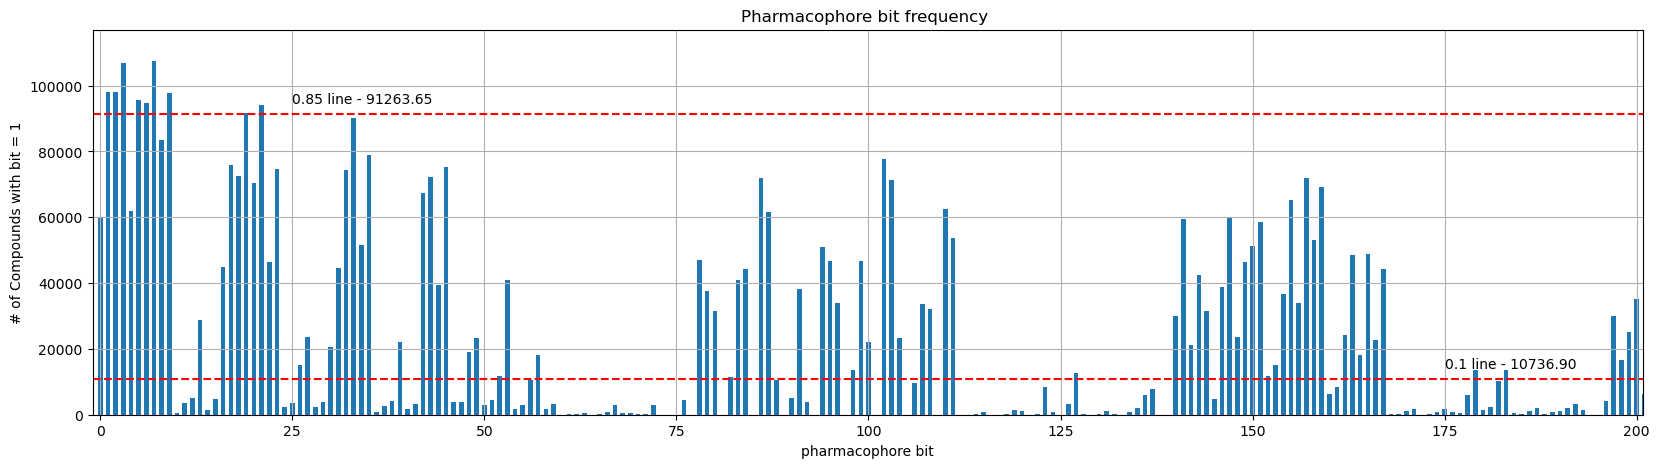

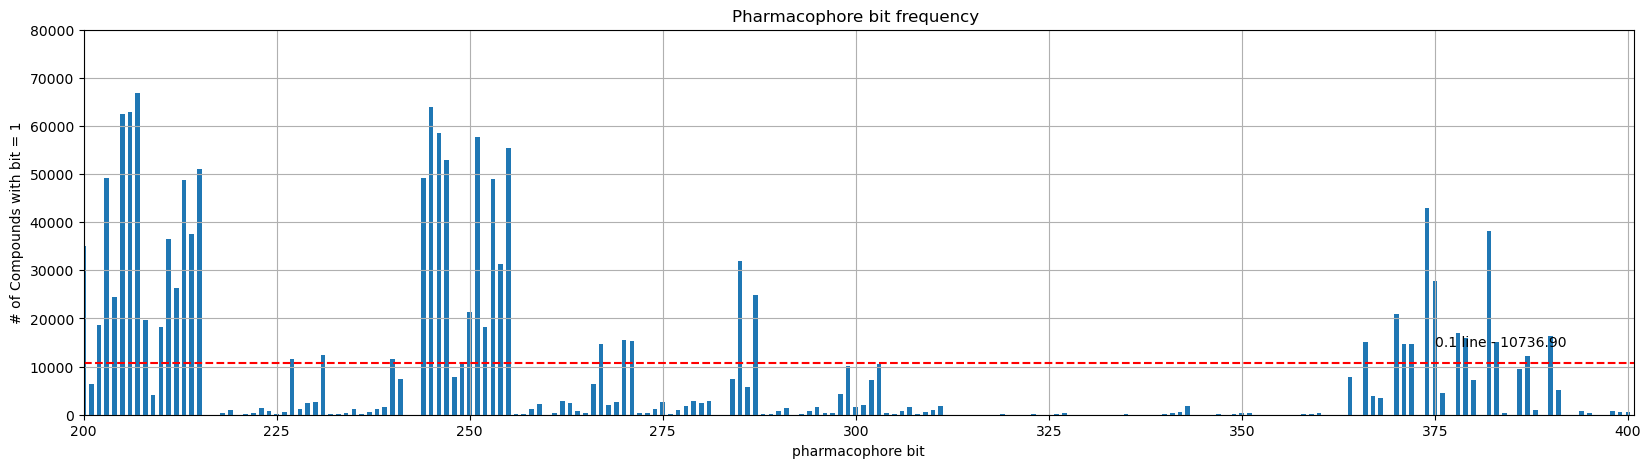

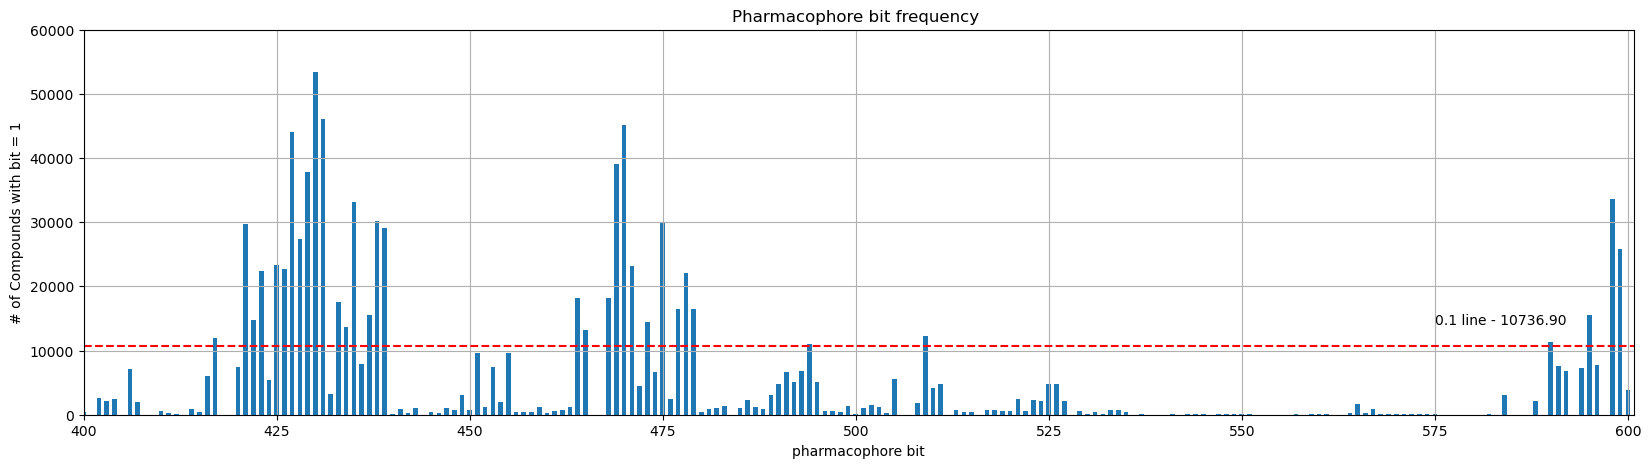

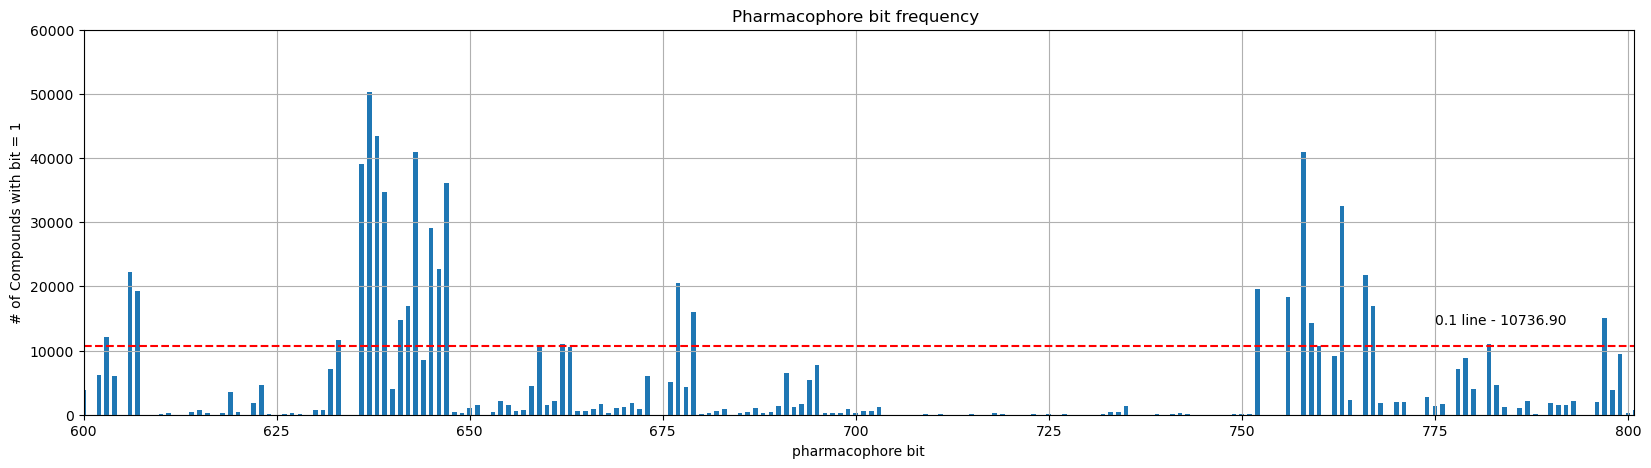

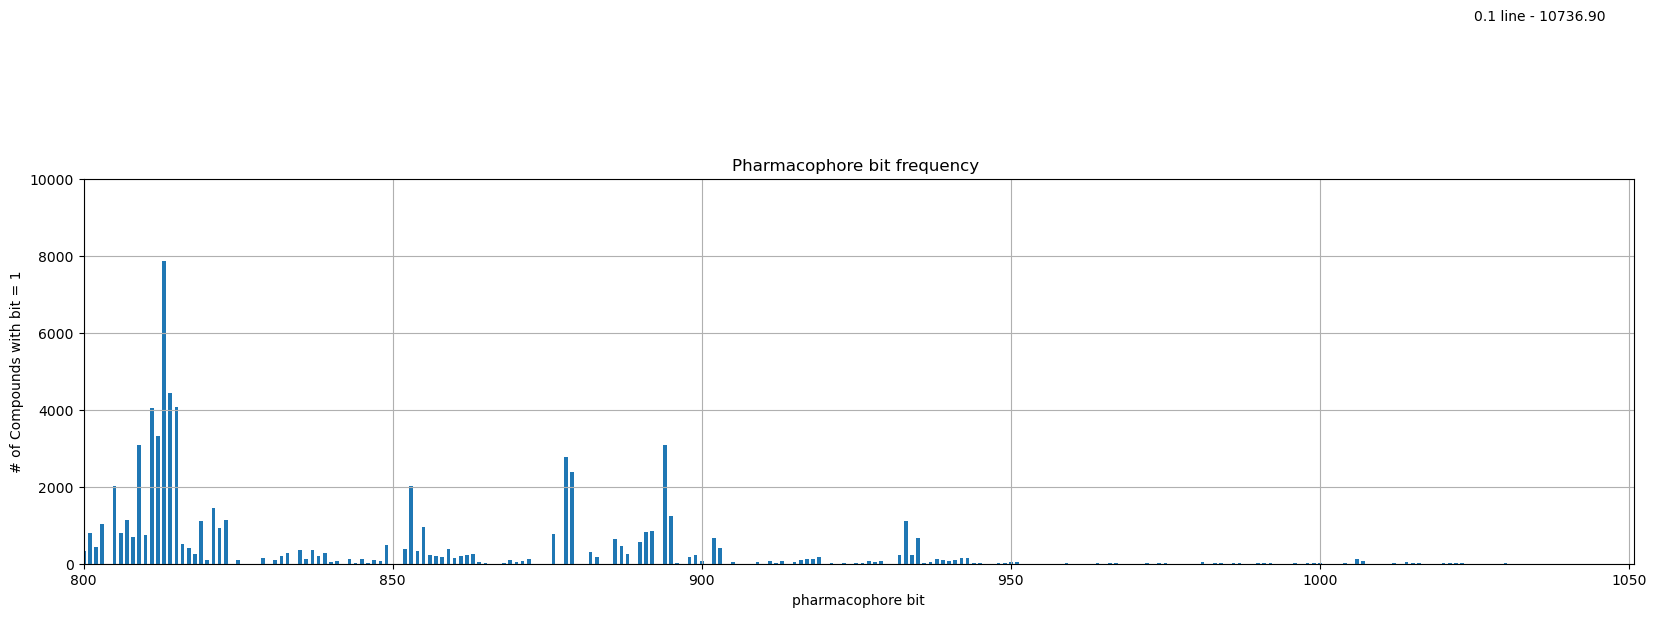

In [381]:
highline =  0.90
lowline =   0.10
box_plot(bit_counter,   0,  200, upper = 117000, highline = 0.85, lowline = 0.10, width = 0.6)
box_plot(bit_counter, 201,  400, upper =  80000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 401,  600, upper =  60000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 601,  800, upper =  60000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 801, 1050, upper =  10000, highline = highline, lowline = lowline, width = 0.6)

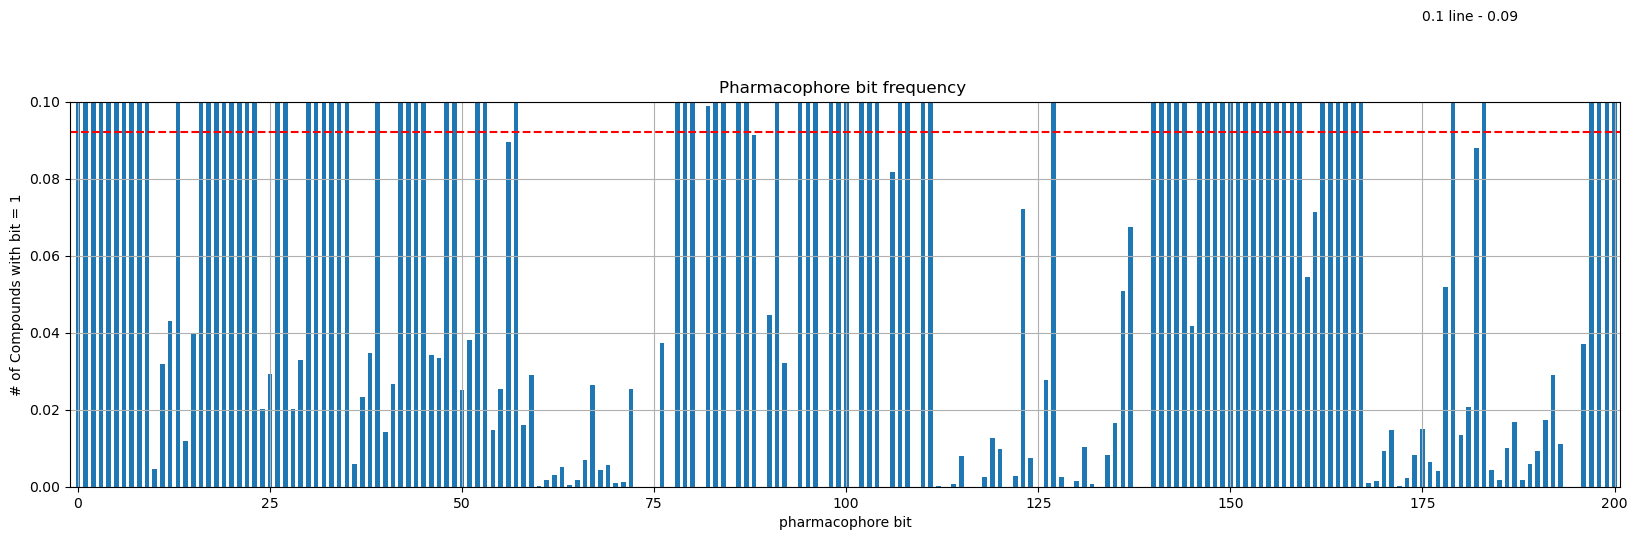

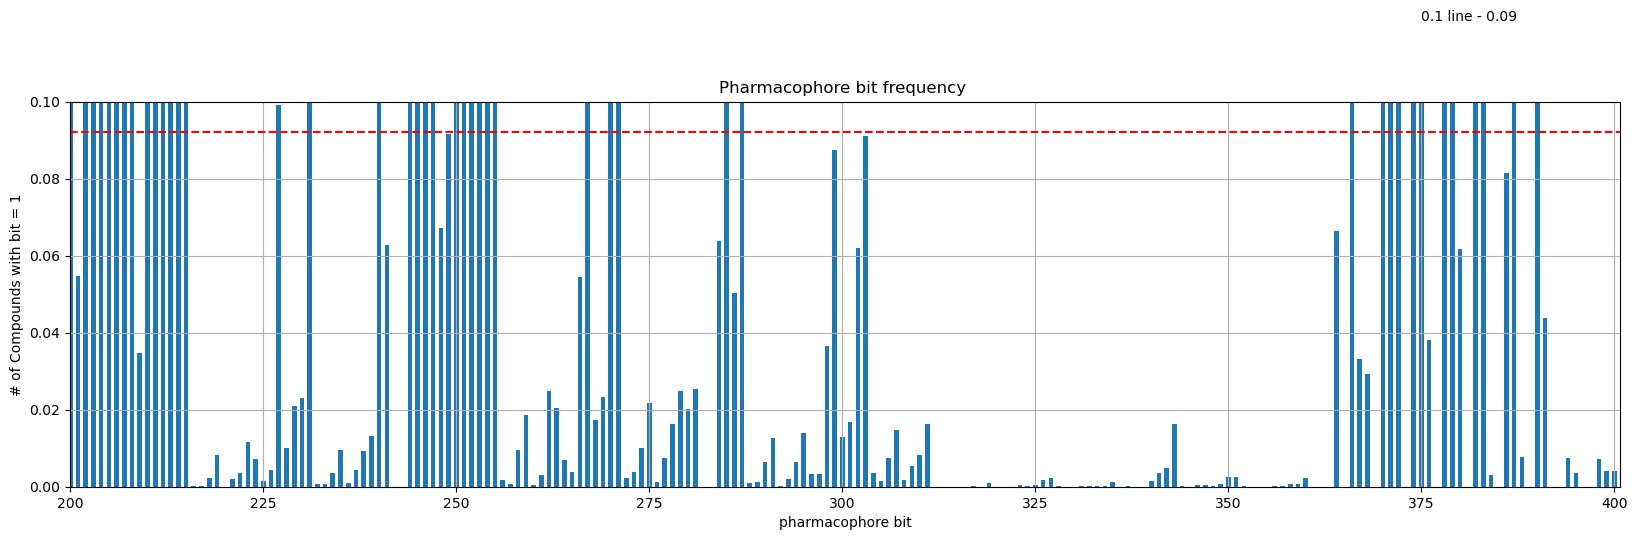

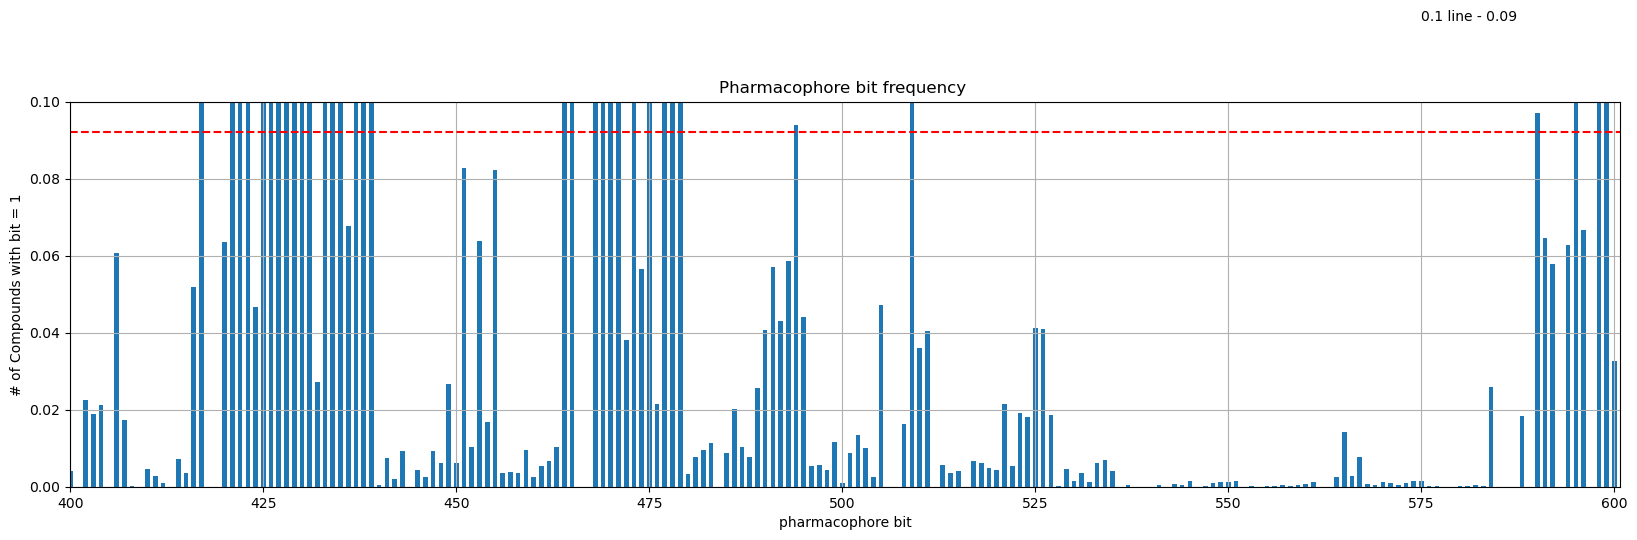

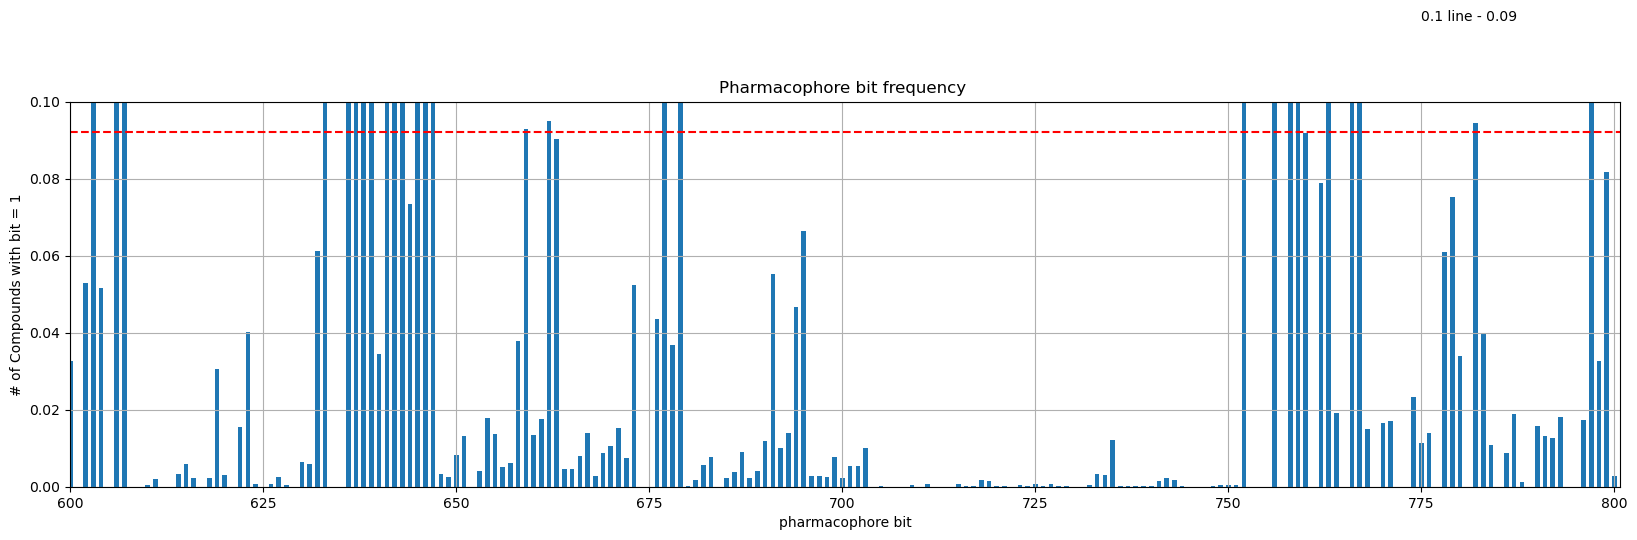

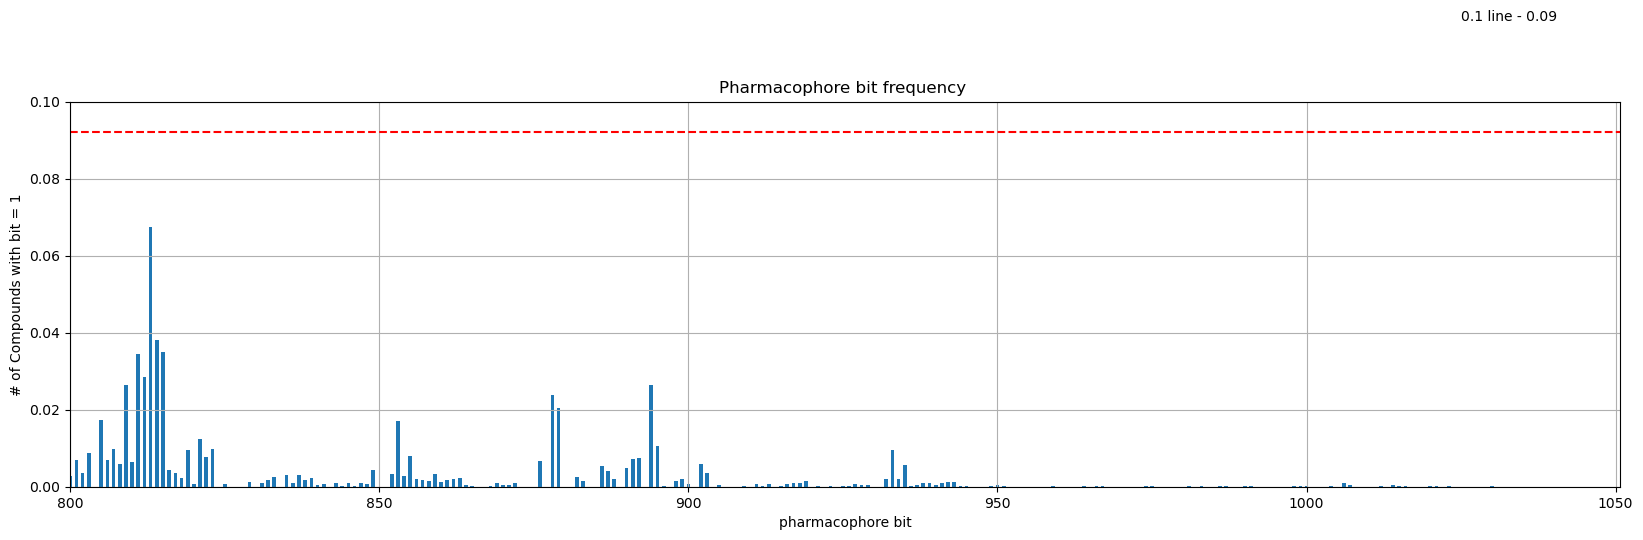

In [382]:
box_plot(bit_counter_pct,   0,  200, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter_pct, 201,  400, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter_pct, 401,  600, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter_pct, 601,  800, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter_pct, 801, 1050, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)

# Create 3 sample phramacophore file

## Read Compound Metadata file

The compounds in followng files match exactly: 

- 3SampleProfiles file `./output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv`
- Compound Extended Metadata Sample file: `./output_10162024/compound_extended_metadata_3samples.csv`


In [846]:
# threeSampleProfiles = './output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
# print(threeSampleProfiles)
# df_profiles =  pd.read_csv(threeSampleProfiles, 
#                         header = 0, skiprows = 0,
#                         usecols = ['Metadata_JCP2022'])

# df_profiles.info()
# df_profiles.head()
# df_profiles.tail()

# df_profiles_sorted = df_profiles.set_index(['Metadata_JCP2022'], drop=False, append = False )
# df_profiles_sorted.sort_index(inplace = True)
# df_profiles_sorted.reset_index(drop = True, inplace = True)
# df_profiles_sorted.drop_duplicates(subset=['Metadata_JCP2022'], keep='first', inplace=True, ignore_index=True)
# df_profiles_sorted.head()
# df_profiles_sorted.tail()

## Verify Extended Metadata file and SampleProfiles file match 

# (df_extMetadata == df_profiles_sorted).all()

In [976]:
print(f" compound Extended Metadata Sample File  : {ds.CompoundExtendedMetadata3SampleFile}\n")

 compound Extended Metadata Sample File  : ./output_10162024/compound_extended_metadata_3samples.csv



In [977]:
df_extMetadata =  pd.read_csv('./output_11102023/compound_extended_metadata_3samples.csv', 
                          usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin'])

In [978]:
df_extMetadata.info()
df_extMetadata.head()
df_extMetadata.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_000001,-8640665944756343816,8
1,JCP2022_000001,-8640665944756343816,8
2,JCP2022_000001,-8640665944756343816,8
3,JCP2022_000002,-2058530355611931119,1
4,JCP2022_000002,-2058530355611931119,1


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346537,JCP2022_116752,8043583690001075349,5
346538,JCP2022_116752,8043583690001075349,5
346539,JCP2022_116753,-9112886486787329276,4
346540,JCP2022_116753,-9112886486787329276,4
346541,JCP2022_116753,-9112886486787329276,4


In [979]:
df_extMetadata.drop_duplicates(subset=['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin'], keep='first', inplace=True, ignore_index=True)


In [980]:
df_extMetadata.info()
df_extMetadata.head()
df_extMetadata.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115514 non-null  object
 1   Metadata_Hash     115514 non-null  int64 
 2   Metadata_Bin      115514 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_000001,-8640665944756343816,8
1,JCP2022_000002,-2058530355611931119,1
2,JCP2022_000004,2222818783381135156,4
3,JCP2022_000005,-5338746385487734035,13
4,JCP2022_000006,-7722642987546231786,6


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
115509,JCP2022_116749,-2319171568672221400,8
115510,JCP2022_116750,9161564570943414536,8
115511,JCP2022_116751,5024933905542715644,12
115512,JCP2022_116752,8043583690001075349,5
115513,JCP2022_116753,-9112886486787329276,4


## Read pharamcophore file 

In [981]:
print(f" Input: compound Pharmacophore File    : {ds.compoundPharmacophoreCSVFile}")
print(f" Output: compound Pharmacophore File    : {ds.compoundPharmacophore3SampleFile}")

 Input: compound Pharmacophore File    : ./output_10162024/compound_pharmacophores.csv
 Output: compound Pharmacophore File    : ./output_10162024/compound_pharmacophores_sparse_3samples.csv


In [982]:
# del df_pharmacophores, df_pharmacophores_3samples
df_pharmacophores = pd.read_csv(ds.compoundPharmacophoreCSVFile)

In [983]:
df_pharmacophores.info()
df_pharmacophores.head(10)
df_pharmacophores.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Columns: 1033 entries, Metadata_JCP2022 to 1031
dtypes: int64(1032), object(1)
memory usage: 919.7+ MB


,Metadata_JCP2022,0,1,2,3,4,5,6,7,8,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000003,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000004,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000005,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_000006,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_000007,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,JCP2022_000008,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,JCP2022_000009,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,JCP2022_000010,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,0,1,2,3,4,5,6,7,8,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
116681,JCP2022_116744,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116682,JCP2022_116745,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
116683,JCP2022_116746,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116684,JCP2022_116747,0,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
116685,JCP2022_116748,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116686,JCP2022_116749,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116687,JCP2022_116750,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
116688,JCP2022_116751,0,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
116689,JCP2022_116752,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
116690,JCP2022_116753,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Join pharmacophores with `Extended_Metadata` 

In [986]:
df_3sample_pharmacophores = pd.merge(df_extMetadata, df_pharmacophores_all, how='left', on=['Metadata_JCP2022'], indicator = False)

In [987]:
# df_3sample_pharmacophores = pd.read_pickle(ds.compoundPharmacophore3SampleFile)

In [988]:
df_3sample_pharmacophores.info()
df_3sample_pharmacophores.head()
df_3sample_pharmacophores.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 912.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115509,JCP2022_116749,-2319171568672221400,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_116750,9161564570943414536,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [989]:
# df_3sample_pharmacophores.Metadata_JCP2022.dtype
# df_3sample_pharmacophores.Metadata_Hash.dtype
# _tmp = df_3sample_pharmacophores.loc[0, 'Metadata_JCP2022']
# _tmp, type(_tmp), len(_tmp)
# _tmp_hash = hash(_tmp)
# _tmp, _tmp_hash, type(_tmp_hash)
_tmp = "JCP2022_000001"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)
_tmp = "JCP2022_000002"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)

('JCP2022_000001', -7496213587281941474, int)

('JCP2022_000002', -6640575950046795234, int)

## Repeat each entry 3 times 

In [ ]:
# df_3samples_pharmacophores = df_3sample_pharmacophores.loc[df_3sample_pharmacophores.index.repeat(3)]

In [990]:
df_3sample_pharmacophores = df_3sample_pharmacophores.loc[df_3sample_pharmacophores.index.repeat(3)]

In [991]:
df_3sample_pharmacophores.info()
df_3sample_pharmacophores.head(5)
df_3sample_pharmacophores.tail(5)

<class 'pandas.core.frame.DataFrame'>
Index: 346542 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.7+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Sort Pharmacophore file in Hash Order 

In [992]:
df_3sample_pharmacophores.reset_index(drop=True, inplace = True)

In [994]:
df_3sample_pharmacophores.head(4)
df_3sample_pharmacophores.tail(4)

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
346538,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346539,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
346540,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
346541,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [995]:
df_3sample_sorted = df_3sample_pharmacophores.set_index(['Metadata_Hash'], drop=False, append = False )
df_3sample_sorted.sort_index(inplace = True)
# df_3sample_sorted

In [996]:
df_3sample_sorted.head(12)
df_3sample_sorted.tail(12)

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
Metadata_Hash,,,,,,,,,,,,,,,,,,,,,
-9223347314827979542,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223347314827979542,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223347314827979542,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223229703754907651,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
-9223229703754907651,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
-9223229703754907651,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
-9223005963369866647,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223005963369866647,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223005963369866647,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
Metadata_Hash,,,,,,,,,,,,,,,,,,,,,
9222418181275619136,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222418181275619136,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222418181275619136,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222499262440709243,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9222499262440709243,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9222499262440709243,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9222528730267146426,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222528730267146426,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222528730267146426,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [997]:
df_3sample_sorted.reset_index(drop = True, inplace = True)

In [998]:
df_3sample_sorted.info()
df_3sample_sorted.head(10)
df_3sample_sorted.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.7+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
346532,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346533,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
346534,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
346535,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
346536,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346537,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346538,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346539,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
346540,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
346541,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Reorder columns if needed 

In [999]:
# new_order_2 = df_3sample_sorted.columns[0:1]
# new_order_2 = new_order_2.append(df_3sample_sorted.columns[-2:] )
# new_order_2    
# new_order_2 = new_order_2.append(df_3sample_sorted.columns[1:-2])
# new_order_2
# new_order_2 = df_3sample_sorted.index(0).append( df_3sample_sorted.index[-2:])
# new_order_2 += df_3sample_sorted.columns[1:-2].tolist()
# new_order_2[:20]
# new_order_2
# dense_mat = dense_mat[new_order]

In [1001]:
# df_3sample_sorted = df_3sample_sorted[new_order_2]

# df_3sample_sorted.head(10)
# df_3sample_sorted.tail(10)

### Write sorted pharmacophore fp file 

In [1004]:
print(f" compound Pharmacophore File    : {ds.compoundPharmacophore3SampleFile}")

 compound Pharmacophore File    : ./output_10162024/compound_pharmacophores_3samples.csv


In [1007]:
df_3sample_sorted.to_csv(ds.compoundPharmacophore3SampleFile, index = False)

In [1008]:
df_3sample_pharmacophores.to_csv("./output_10162024/3_sample_profiles/3sample_pharmacophores_1482_CompoundOrder_all.csv", mode = 'w', index = False, header = True)
df_3sample_sorted.to_csv("./output_10162024/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_all.csv", mode = 'w', index = False, header = True)

In [1009]:
df_3sample_pharmacophores.to_csv("./output_11102023/3_sample_profiles/3sample_pharmacophores_1482_CompoundOrder_all.csv", mode = 'w', index = False, header = True)
df_3sample_sorted.to_csv("./output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_all.csv", mode = 'w', index = False, header = True)

In [1014]:
# del df_extMetadata, df_pharmacophores_all, df_3sample_pharmacophores, df_3sample_sorted, df_fingerprints_all
# del df_fprints, df_md_nan, df_md_zero, df_metadata_all, df_nan, df_iterator, df_pfp, df_md_inv, df_pharmacophores
# del df_profiles, df_profiles_sorted, df_samples, df_samples_dedupe, df_samples_flags, df_temp, df_test 
del

# Comprare the 3sample profile and fingerprint file to make sure trey match on key fields 

In [919]:
# del file_reader_1

In [920]:
df_profiles =  pd.read_csv('./output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv', 
                        header = 0, skiprows = 0,
                        usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',],)

In [1017]:
# df_profiles.drop_duplicates(subset=['Metadata_JCP2022'], keep='first', inplace=True, ignore_index=True)

In [1018]:
df_profiles.info()
df_profiles.head(5)
df_profiles.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_006020,-9223347314827979542,10
1,JCP2022_006020,-9223347314827979542,10
2,JCP2022_006020,-9223347314827979542,10
3,JCP2022_058905,-9223229703754907651,13
4,JCP2022_058905,-9223229703754907651,13


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346537,JCP2022_040466,9222528730267146426,10
346538,JCP2022_040466,9222528730267146426,10
346539,JCP2022_102583,9223213570900537648,0
346540,JCP2022_102583,9223213570900537648,0
346541,JCP2022_102583,9223213570900537648,0


In [1021]:
df_pfp = pd.read_csv('./output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_all.csv',
                        header = 0,
                        skiprows = 0,
                        usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin' ])
df_pfp.info()
df_pfp.head(10)
df_pfp.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_006020,-9223347314827979542,10
1,JCP2022_006020,-9223347314827979542,10
2,JCP2022_006020,-9223347314827979542,10
3,JCP2022_058905,-9223229703754907651,13
4,JCP2022_058905,-9223229703754907651,13
5,JCP2022_058905,-9223229703754907651,13
6,JCP2022_051160,-9223005963369866647,9
7,JCP2022_051160,-9223005963369866647,9
8,JCP2022_051160,-9223005963369866647,9
9,JCP2022_038591,-9222975330808494972,4


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346532,JCP2022_110705,9222418181275619136,0
346533,JCP2022_017353,9222499262440709243,11
346534,JCP2022_017353,9222499262440709243,11
346535,JCP2022_017353,9222499262440709243,11
346536,JCP2022_040466,9222528730267146426,10
346537,JCP2022_040466,9222528730267146426,10
346538,JCP2022_040466,9222528730267146426,10
346539,JCP2022_102583,9223213570900537648,0
346540,JCP2022_102583,9223213570900537648,0
346541,JCP2022_102583,9223213570900537648,0


In [1022]:
df_profiles.info()
df_pfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


In [1023]:
idx1 =  0
ttl_mismatch = 0
len(df_pfp)

346542

In [1024]:
for idx1 in range(0, 346_542):
    if idx1 % 10000 == 0:
        print(f" {idx1} rows read . . . ")
    for j in range(3):
        if (df_profiles.iloc[idx1, j ] !=  df_pfp.iloc[idx1,j]):
            print(f" row: {idx1} col {j} - values differ:  {df_profiles.iloc[idx1, j ]} !=  {df_pfp.iloc[idx1,j]} ")
            ttl_mismatch += 1
            break
print(f" {idx1+1} rows read")

 0 rows read . . . 
 10000 rows read . . . 
 20000 rows read . . . 
 30000 rows read . . . 
 40000 rows read . . . 
 50000 rows read . . . 
 60000 rows read . . . 
 70000 rows read . . . 
 80000 rows read . . . 
 90000 rows read . . . 
 100000 rows read . . . 
 110000 rows read . . . 
 120000 rows read . . . 
 130000 rows read . . . 
 140000 rows read . . . 
 150000 rows read . . . 
 160000 rows read . . . 
 170000 rows read . . . 
 180000 rows read . . . 
 190000 rows read . . . 
 200000 rows read . . . 
 210000 rows read . . . 
 220000 rows read . . . 
 230000 rows read . . . 
 240000 rows read . . . 
 250000 rows read . . . 
 260000 rows read . . . 
 270000 rows read . . . 
 280000 rows read . . . 
 290000 rows read . . . 
 300000 rows read . . . 
 310000 rows read . . . 
 320000 rows read . . . 
 330000 rows read . . . 
 340000 rows read . . . 


# (Obsolete) Drop TPSA == 0 rows from df_pharamcophore file 

### Read Pharmacophore fingerprint 
(Sparse Bit Vector format)  `./output/cp_compound_pharmacophores_sparsebitvec.pkl`  and check it

In [73]:
print(compoundPharmacophoreFile)

./output_11102023/_compound_pharmacophores_sparse.pkl


In [73]:
df = pd.read_pickle(compoundPharmacophoreFile)
df.info()
df.head(10)
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116751 non-null  object
 1   pharmacophore_fp  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
5,JCP2022_000006,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,JCP2022_000007,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
7,JCP2022_000008,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
8,JCP2022_000009,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
9,JCP2022_000010,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,JCP2022,pharmacophore_fp
116741,JCP2022_116744,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116742,JCP2022_116745,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116743,JCP2022_116746,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116744,JCP2022_116747,"[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
116745,JCP2022_116748,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116746,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116747,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116750,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


In [74]:

print(type(df.at[0, 'pharmacophore_fp']), len(df.at[0, 'pharmacophore_fp']),  df.at[0, 'pharmacophore_fp'])
print(type(df.loc[0].pharmacophore_fp)  , len(df.loc[0].pharmacophore_fp)  ,  df.loc[0].pharmacophore_fp)
print(type(df.iloc[0].pharmacophore_fp) , len(df.iloc[0].pharmacophore_fp) ,  df.iloc[0].pharmacophore_fp)
# print(type(df[0].pharmacophore_fp) , len(df[0].pharmacophore_fp) ,  df[0].pharmacophore_fp)


<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7f4775000130>


In [75]:
df[df['JCP2022'].isna()]
len(df)
df[df['pharmacophore_fp'].isna()]
len(df)


,JCP2022,pharmacophore_fp


116751

,JCP2022,pharmacophore_fp


116751

In [76]:
del df

### Read pharamcophore file

In [76]:
df_pharmacophores = pd.read_pickle(compoundPharmacophoreFile)
df_pharmacophores.info()
df_pharmacophores.head(3)
df_pharmacophores.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116751 non-null  object
 1   pharmacophore_fp  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,JCP2022,pharmacophore_fp
116748,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116749,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116750,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


### drop df_pharmacophore rows where corresponding  TPSA == 0

In [1]:
# df_pharmacophores.drop(index=md_drop_indices, inplace=True)
# len(df_pharmacophores)
# df_pharmacophores


In [93]:
# df_pharmacophores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   JCP2022           116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


### write to `cp_compound_pharmacophores_sparse_clean.pkl`

In [103]:
# print(f" compound Pharmacophore Clean Pickle File       : {compoundPharmacophoreCleanFile}")

 compound Pharmacophore Clean Pickle File       : ./output/cp_compound_pharmacophores_sparse_clean.pkl


In [104]:
# df_pharmacophores.to_pickle(compoundPharmacophoreCleanFile)